# Afriat

In [1]:
ood_seed = 9

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('24', 'Pericentral', 'Infected')


Removed datapoint: 760

train         14630
validation     3663
ood             760
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 54%|█████▍    | 10331/19053 [00:00<00:00, 103299.51it/s]

100%|██████████| 19053/19053 [00:00<00:00, 105126.17it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1120248.88it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 432.09it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:12,  9.20s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:01:12,  9.20s/it, v_num=1, recon=4e+3, r2_mean=0.197, adv_loss=3.29, acc_pert=0.242, acc_zone=0.737, acc_status_control=0.515]

Epoch 2/400:   0%|          | 1/400 [00:09<1:01:12,  9.20s/it, v_num=1, recon=4e+3, r2_mean=0.197, adv_loss=3.29, acc_pert=0.242, acc_zone=0.737, acc_status_control=0.515]

Epoch 2/400:   0%|          | 2/400 [00:18<1:00:08,  9.07s/it, v_num=1, recon=4e+3, r2_mean=0.197, adv_loss=3.29, acc_pert=0.242, acc_zone=0.737, acc_status_control=0.515]

Epoch 2/400:   0%|          | 2/400 [00:18<1:00:08,  9.07s/it, v_num=1, recon=3.28e+3, r2_mean=0.61, adv_loss=2.84, acc_pert=0.374, acc_zone=0.807, acc_status_control=0.65]

Epoch 3/400:   0%|          | 2/400 [00:18<1:00:08,  9.07s/it, v_num=1, recon=3.28e+3, r2_mean=0.61, adv_loss=2.84, acc_pert=0.374, acc_zone=0.807, acc_status_control=0.65]

Epoch 3/400:   1%|          | 3/400 [00:27<59:31,  9.00s/it, v_num=1, recon=3.28e+3, r2_mean=0.61, adv_loss=2.84, acc_pert=0.374, acc_zone=0.807, acc_status_control=0.65]  

Epoch 3/400:   1%|          | 3/400 [00:27<59:31,  9.00s/it, v_num=1, recon=3.22e+3, r2_mean=0.711, adv_loss=2.76, acc_pert=0.376, acc_zone=0.822, acc_status_control=0.652]

Epoch 4/400:   1%|          | 3/400 [00:27<59:31,  9.00s/it, v_num=1, recon=3.22e+3, r2_mean=0.711, adv_loss=2.76, acc_pert=0.376, acc_zone=0.822, acc_status_control=0.652]

Epoch 4/400:   1%|          | 4/400 [00:35<59:02,  8.95s/it, v_num=1, recon=3.22e+3, r2_mean=0.711, adv_loss=2.76, acc_pert=0.376, acc_zone=0.822, acc_status_control=0.652]

Epoch 4/400:   1%|          | 4/400 [00:35<59:02,  8.95s/it, v_num=1, recon=3.2e+3, r2_mean=0.75, adv_loss=2.74, acc_pert=0.385, acc_zone=0.835, acc_status_control=0.643]  

Epoch 5/400:   1%|          | 4/400 [00:35<59:02,  8.95s/it, v_num=1, recon=3.2e+3, r2_mean=0.75, adv_loss=2.74, acc_pert=0.385, acc_zone=0.835, acc_status_control=0.643]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:38,  8.91s/it, v_num=1, recon=3.2e+3, r2_mean=0.75, adv_loss=2.74, acc_pert=0.385, acc_zone=0.835, acc_status_control=0.643]

Epoch 5/400:   1%|▏         | 5/400 [00:44<58:38,  8.91s/it, v_num=1, recon=3.19e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.482, acc_zone=0.84, acc_status_control=0.649]

Epoch 6/400:   1%|▏         | 5/400 [00:44<58:38,  8.91s/it, v_num=1, recon=3.19e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.482, acc_zone=0.84, acc_status_control=0.649]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:24,  8.89s/it, v_num=1, recon=3.19e+3, r2_mean=0.77, adv_loss=2.53, acc_pert=0.482, acc_zone=0.84, acc_status_control=0.649]

Epoch 6/400:   2%|▏         | 6/400 [00:53<58:24,  8.89s/it, v_num=1, recon=3.18e+3, r2_mean=0.787, adv_loss=2.3, acc_pert=0.556, acc_zone=0.849, acc_status_control=0.654]

Epoch 7/400:   2%|▏         | 6/400 [00:53<58:24,  8.89s/it, v_num=1, recon=3.18e+3, r2_mean=0.787, adv_loss=2.3, acc_pert=0.556, acc_zone=0.849, acc_status_control=0.654]

Epoch 7/400:   2%|▏         | 7/400 [01:02<58:24,  8.92s/it, v_num=1, recon=3.18e+3, r2_mean=0.787, adv_loss=2.3, acc_pert=0.556, acc_zone=0.849, acc_status_control=0.654]

Epoch 7/400:   2%|▏         | 7/400 [01:02<58:24,  8.92s/it, v_num=1, recon=3.17e+3, r2_mean=0.795, adv_loss=2.17, acc_pert=0.591, acc_zone=0.853, acc_status_control=0.663]

Epoch 8/400:   2%|▏         | 7/400 [01:02<58:24,  8.92s/it, v_num=1, recon=3.17e+3, r2_mean=0.795, adv_loss=2.17, acc_pert=0.591, acc_zone=0.853, acc_status_control=0.663]

Epoch 8/400:   2%|▏         | 8/400 [01:11<58:14,  8.91s/it, v_num=1, recon=3.17e+3, r2_mean=0.795, adv_loss=2.17, acc_pert=0.591, acc_zone=0.853, acc_status_control=0.663]

Epoch 8/400:   2%|▏         | 8/400 [01:11<58:14,  8.91s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.04, acc_pert=0.629, acc_zone=0.856, acc_status_control=0.672]

Epoch 9/400:   2%|▏         | 8/400 [01:11<58:14,  8.91s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.04, acc_pert=0.629, acc_zone=0.856, acc_status_control=0.672]

Epoch 9/400:   2%|▏         | 9/400 [01:20<58:04,  8.91s/it, v_num=1, recon=3.16e+3, r2_mean=0.804, adv_loss=2.04, acc_pert=0.629, acc_zone=0.856, acc_status_control=0.672]

Epoch 9/400:   2%|▏         | 9/400 [01:20<58:04,  8.91s/it, v_num=1, recon=3.15e+3, r2_mean=0.806, adv_loss=2.02, acc_pert=0.632, acc_zone=0.858, acc_status_control=0.668]

Epoch 10/400:   2%|▏         | 9/400 [01:20<58:04,  8.91s/it, v_num=1, recon=3.15e+3, r2_mean=0.806, adv_loss=2.02, acc_pert=0.632, acc_zone=0.858, acc_status_control=0.668]


disnt_basal = 1.2353818229467117

disnt_after = 1.893906735575412

val_r2_mean = 0.8075013482890285

val_r2_var = 0.1839884749385055


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:33<1:06:54, 10.29s/it, v_num=1, recon=3.15e+3, r2_mean=0.806, adv_loss=2.02, acc_pert=0.632, acc_zone=0.858, acc_status_control=0.668]

Epoch 10/400:   2%|▎         | 10/400 [01:33<1:06:54, 10.29s/it, v_num=1, recon=3.14e+3, r2_mean=0.812, adv_loss=2, acc_pert=0.651, acc_zone=0.862, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:33<1:06:54, 10.29s/it, v_num=1, recon=3.14e+3, r2_mean=0.812, adv_loss=2, acc_pert=0.651, acc_zone=0.862, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:42<1:04:00,  9.87s/it, v_num=1, recon=3.14e+3, r2_mean=0.812, adv_loss=2, acc_pert=0.651, acc_zone=0.862, acc_status_control=0.663, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:42<1:04:00,  9.87s/it, v_num=1, recon=3.14e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.663, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:42<1:04:00,  9.87s/it, v_num=1, recon=3.14e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.663, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:51<1:01:55,  9.57s/it, v_num=1, recon=3.14e+3, r2_mean=0.813, adv_loss=1.97, acc_pert=0.663, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:51<1:01:55,  9.57s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.671, acc_zone=0.864, acc_status_control=0.657, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:51<1:01:55,  9.57s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.671, acc_zone=0.864, acc_status_control=0.657, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:00<1:00:24,  9.37s/it, v_num=1, recon=3.14e+3, r2_mean=0.815, adv_loss=1.95, acc_pert=0.671, acc_zone=0.864, acc_status_control=0.657, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [02:00<1:00:24,  9.37s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=1.9, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.666, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [02:00<1:00:24,  9.37s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=1.9, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.666, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:09<59:20,  9.23s/it, v_num=1, recon=3.13e+3, r2_mean=0.817, adv_loss=1.9, acc_pert=0.692, acc_zone=0.862, acc_status_control=0.666, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]  

Epoch 14/400:   4%|▎         | 14/400 [02:09<59:20,  9.23s/it, v_num=1, recon=3.12e+3, r2_mean=0.82, adv_loss=1.91, acc_pert=0.686, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:09<59:20,  9.23s/it, v_num=1, recon=3.12e+3, r2_mean=0.82, adv_loss=1.91, acc_pert=0.686, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:18<58:33,  9.13s/it, v_num=1, recon=3.12e+3, r2_mean=0.82, adv_loss=1.91, acc_pert=0.686, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:18<58:33,  9.13s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.9, acc_pert=0.687, acc_zone=0.861, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 15/400 [02:18<58:33,  9.13s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.9, acc_pert=0.687, acc_zone=0.861, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:27<58:05,  9.08s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.9, acc_pert=0.687, acc_zone=0.861, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:27<58:05,  9.08s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.89, acc_pert=0.69, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:27<58:05,  9.08s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.89, acc_pert=0.69, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:36<57:33,  9.02s/it, v_num=1, recon=3.12e+3, r2_mean=0.822, adv_loss=1.89, acc_pert=0.69, acc_zone=0.861, acc_status_control=0.661, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:36<57:33,  9.02s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.87, acc_pert=0.695, acc_zone=0.863, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 17/400 [02:36<57:33,  9.02s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.87, acc_pert=0.695, acc_zone=0.863, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:45<57:12,  8.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.822, adv_loss=1.87, acc_pert=0.695, acc_zone=0.863, acc_status_control=0.662, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:45<57:12,  8.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.86, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:45<57:12,  8.99s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.86, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:54<57:01,  8.98s/it, v_num=1, recon=3.11e+3, r2_mean=0.823, adv_loss=1.86, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.665, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:54<57:01,  8.98s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.83, acc_pert=0.705, acc_zone=0.86, acc_status_control=0.671, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]  

Epoch 20/400:   5%|▍         | 19/400 [02:54<57:01,  8.98s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.83, acc_pert=0.705, acc_zone=0.86, acc_status_control=0.671, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]


disnt_basal = 1.2228403889207675

disnt_after = 1.8953477947848418

val_r2_mean = 0.8246424977198294

val_r2_var = 0.2058635881413788


Epoch 00019: cpa_metric reached. Module best state updated.


Epoch 20/400:   5%|▌         | 20/400 [03:07<1:05:24, 10.33s/it, v_num=1, recon=3.1e+3, r2_mean=0.824, adv_loss=1.83, acc_pert=0.705, acc_zone=0.86, acc_status_control=0.671, val_recon=3.13e+3, disnt_basal=1.24, disnt_after=1.89, val_r2_mean=0.808, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:07<1:05:24, 10.33s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=1.84, acc_pert=0.701, acc_zone=0.86, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [03:07<1:05:24, 10.33s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=1.84, acc_pert=0.701, acc_zone=0.86, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:16<1:02:31,  9.90s/it, v_num=1, recon=3.1e+3, r2_mean=0.823, adv_loss=1.84, acc_pert=0.701, acc_zone=0.86, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:16<1:02:31,  9.90s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.85, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:16<1:02:31,  9.90s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.85, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:25<1:00:37,  9.62s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.85, acc_pert=0.702, acc_zone=0.863, acc_status_control=0.671, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:25<1:00:37,  9.62s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.83, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.669, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [03:25<1:00:37,  9.62s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.83, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.669, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:34<59:00,  9.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.825, adv_loss=1.83, acc_pert=0.695, acc_zone=0.86, acc_status_control=0.669, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]  

Epoch 23/400:   6%|▌         | 23/400 [03:34<59:00,  9.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.84, acc_pert=0.694, acc_zone=0.86, acc_status_control=0.673, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:34<59:00,  9.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.84, acc_pert=0.694, acc_zone=0.86, acc_status_control=0.673, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:43<57:51,  9.23s/it, v_num=1, recon=3.09e+3, r2_mean=0.824, adv_loss=1.84, acc_pert=0.694, acc_zone=0.86, acc_status_control=0.673, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:43<57:51,  9.23s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.83, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.677, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 25/400:   6%|▌         | 24/400 [03:43<57:51,  9.23s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.83, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.677, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:51<56:59,  9.12s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.83, acc_pert=0.693, acc_zone=0.858, acc_status_control=0.677, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:51<56:59,  9.12s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.82, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.681, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:51<56:59,  9.12s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.82, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.681, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:00<56:18,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.82, acc_pert=0.694, acc_zone=0.859, acc_status_control=0.681, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [04:00<56:18,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.82, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.679, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 27/400:   6%|▋         | 26/400 [04:00<56:18,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.82, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.679, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:09<55:48,  8.98s/it, v_num=1, recon=3.08e+3, r2_mean=0.827, adv_loss=1.82, acc_pert=0.694, acc_zone=0.862, acc_status_control=0.679, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:09<55:48,  8.98s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.84, acc_pert=0.691, acc_zone=0.857, acc_status_control=0.683, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:09<55:48,  8.98s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.84, acc_pert=0.691, acc_zone=0.857, acc_status_control=0.683, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:18<55:28,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.828, adv_loss=1.84, acc_pert=0.691, acc_zone=0.857, acc_status_control=0.683, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:18<55:28,  8.95s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.82, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.684, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:18<55:28,  8.95s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.82, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.684, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:27<55:12,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.82, acc_pert=0.699, acc_zone=0.862, acc_status_control=0.684, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:27<55:12,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.83, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.68, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]   

Epoch 30/400:   7%|▋         | 29/400 [04:27<55:12,  8.93s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.83, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.68, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.2347391287171896

disnt_after = 1.874216223030342

val_r2_mean = 0.8293657517383966

val_r2_var = 0.24187591938265232

Epoch 30/400:   8%|▊         | 30/400 [04:40<1:03:26, 10.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.83, adv_loss=1.83, acc_pert=0.692, acc_zone=0.86, acc_status_control=0.68, val_recon=3.09e+3, disnt_basal=1.22, disnt_after=1.9, val_r2_mean=0.825, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:40<1:03:26, 10.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.85, acc_pert=0.69, acc_zone=0.855, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:40<1:03:26, 10.29s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.85, acc_pert=0.69, acc_zone=0.855, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:49<1:00:48,  9.89s/it, v_num=1, recon=3.07e+3, r2_mean=0.829, adv_loss=1.85, acc_pert=0.69, acc_zone=0.855, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:49<1:00:48,  9.89s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.697, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [04:49<1:00:48,  9.89s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.697, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:58<58:53,  9.60s/it, v_num=1, recon=3.06e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.697, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]  

Epoch 32/400:   8%|▊         | 32/400 [04:58<58:53,  9.60s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.698, acc_zone=0.859, acc_status_control=0.683, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:58<58:53,  9.60s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.698, acc_zone=0.859, acc_status_control=0.683, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:07<57:23,  9.38s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.698, acc_zone=0.859, acc_status_control=0.683, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:07<57:23,  9.38s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.83, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.679, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan] 

Epoch 34/400:   8%|▊         | 33/400 [05:07<57:23,  9.38s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.83, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.679, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:16<56:29,  9.26s/it, v_num=1, recon=3.06e+3, r2_mean=0.831, adv_loss=1.83, acc_pert=0.699, acc_zone=0.86, acc_status_control=0.679, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:16<56:29,  9.26s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.696, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:16<56:29,  9.26s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.696, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:25<55:47,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.696, acc_zone=0.859, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:25<55:47,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.701, acc_zone=0.854, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:25<55:47,  9.17s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.701, acc_zone=0.854, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:34<55:09,  9.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.83, adv_loss=1.82, acc_pert=0.701, acc_zone=0.854, acc_status_control=0.681, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:34<55:09,  9.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.83, acc_pert=0.698, acc_zone=0.858, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:34<55:09,  9.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.83, acc_pert=0.698, acc_zone=0.858, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:43<54:41,  9.04s/it, v_num=1, recon=3.05e+3, r2_mean=0.833, adv_loss=1.83, acc_pert=0.698, acc_zone=0.858, acc_status_control=0.68, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:43<54:41,  9.04s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.704, acc_zone=0.857, acc_status_control=0.686, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:   9%|▉         | 37/400 [05:43<54:41,  9.04s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.704, acc_zone=0.857, acc_status_control=0.686, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:52<54:11,  8.98s/it, v_num=1, recon=3.05e+3, r2_mean=0.831, adv_loss=1.82, acc_pert=0.704, acc_zone=0.857, acc_status_control=0.686, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:52<54:11,  8.98s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.81, acc_pert=0.704, acc_zone=0.86, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan] 

Epoch 39/400:  10%|▉         | 38/400 [05:52<54:11,  8.98s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.81, acc_pert=0.704, acc_zone=0.86, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:01<53:50,  8.95s/it, v_num=1, recon=3.04e+3, r2_mean=0.829, adv_loss=1.81, acc_pert=0.704, acc_zone=0.86, acc_status_control=0.684, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [06:01<53:50,  8.95s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.83, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.682, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan] 

Epoch 40/400:  10%|▉         | 39/400 [06:01<53:50,  8.95s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.83, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.682, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.220011293582775

disnt_after = 1.8708098708512917

val_r2_mean = 0.834113854459644

val_r2_var = 0.24212074946858703

Epoch 40/400:  10%|█         | 40/400 [06:14<1:01:51, 10.31s/it, v_num=1, recon=3.04e+3, r2_mean=0.832, adv_loss=1.83, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.682, val_recon=3.05e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.829, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:14<1:01:51, 10.31s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.678, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:14<1:01:51, 10.31s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.678, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:23<59:06,  9.88s/it, v_num=1, recon=3.04e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.855, acc_status_control=0.678, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [06:23<59:06,  9.88s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.84, acc_pert=0.699, acc_zone=0.858, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [06:23<59:06,  9.88s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.84, acc_pert=0.699, acc_zone=0.858, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:32<57:10,  9.58s/it, v_num=1, recon=3.04e+3, r2_mean=0.831, adv_loss=1.84, acc_pert=0.699, acc_zone=0.858, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:32<57:10,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.856, acc_status_control=0.686, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 43/400:  10%|█         | 42/400 [06:32<57:10,  9.58s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.856, acc_status_control=0.686, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:41<55:59,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.834, adv_loss=1.84, acc_pert=0.7, acc_zone=0.856, acc_status_control=0.686, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:41<55:59,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.85, acc_pert=0.704, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [06:41<55:59,  9.41s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.85, acc_pert=0.704, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:50<54:49,  9.24s/it, v_num=1, recon=3.03e+3, r2_mean=0.831, adv_loss=1.85, acc_pert=0.704, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:50<54:49,  9.24s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.85, acc_pert=0.698, acc_zone=0.855, acc_status_control=0.684, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [06:50<54:49,  9.24s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.85, acc_pert=0.698, acc_zone=0.855, acc_status_control=0.684, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:59<54:00,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.833, adv_loss=1.85, acc_pert=0.698, acc_zone=0.855, acc_status_control=0.684, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:59<54:00,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.84, acc_pert=0.7, acc_zone=0.854, acc_status_control=0.681, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 46/400:  11%|█▏        | 45/400 [06:59<54:00,  9.13s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.84, acc_pert=0.7, acc_zone=0.854, acc_status_control=0.681, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:08<53:32,  9.08s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.84, acc_pert=0.7, acc_zone=0.854, acc_status_control=0.681, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:08<53:32,  9.08s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.85, acc_pert=0.7, acc_zone=0.858, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 47/400:  12%|█▏        | 46/400 [07:08<53:32,  9.08s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.85, acc_pert=0.7, acc_zone=0.858, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:16<53:01,  9.01s/it, v_num=1, recon=3.03e+3, r2_mean=0.832, adv_loss=1.85, acc_pert=0.7, acc_zone=0.858, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:16<53:01,  9.01s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.87, acc_pert=0.691, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:16<53:01,  9.01s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.87, acc_pert=0.691, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:25<52:48,  9.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.833, adv_loss=1.87, acc_pert=0.691, acc_zone=0.856, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:25<52:48,  9.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.88, acc_pert=0.688, acc_zone=0.854, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:25<52:48,  9.00s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.88, acc_pert=0.688, acc_zone=0.854, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:34<52:28,  8.97s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.88, acc_pert=0.688, acc_zone=0.854, acc_status_control=0.683, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:34<52:28,  8.97s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.87, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 50/400:  12%|█▏        | 49/400 [07:34<52:28,  8.97s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.87, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2212168763121605

disnt_after = 1.8674612373684625

val_r2_mean = 0.8336898805941197

val_r2_var = 0.2706677039108186

Epoch 50/400:  12%|█▎        | 50/400 [07:48<59:53, 10.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.831, adv_loss=1.87, acc_pert=0.694, acc_zone=0.854, acc_status_control=0.68, val_recon=3.03e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:48<59:53, 10.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.88, acc_pert=0.689, acc_zone=0.855, acc_status_control=0.683, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 51/400:  12%|█▎        | 50/400 [07:48<59:53, 10.27s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.88, acc_pert=0.689, acc_zone=0.855, acc_status_control=0.683, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:56<57:19,  9.85s/it, v_num=1, recon=3.02e+3, r2_mean=0.832, adv_loss=1.88, acc_pert=0.689, acc_zone=0.855, acc_status_control=0.683, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:56<57:19,  9.85s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.88, acc_pert=0.685, acc_zone=0.854, acc_status_control=0.68, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 52/400:  13%|█▎        | 51/400 [07:56<57:19,  9.85s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.88, acc_pert=0.685, acc_zone=0.854, acc_status_control=0.68, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:05<55:29,  9.57s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.88, acc_pert=0.685, acc_zone=0.854, acc_status_control=0.68, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [08:05<55:29,  9.57s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [08:05<55:29,  9.57s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:14<54:04,  9.35s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.684, acc_zone=0.855, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:14<54:04,  9.35s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.682, acc_zone=0.853, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:14<54:04,  9.35s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.682, acc_zone=0.853, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:23<53:11,  9.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.682, acc_zone=0.853, acc_status_control=0.678, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:23<53:11,  9.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 55/400:  14%|█▎        | 54/400 [08:23<53:11,  9.22s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:32<52:31,  9.13s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:32<52:31,  9.13s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:32<52:31,  9.13s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:41<52:00,  9.07s/it, v_num=1, recon=3.01e+3, r2_mean=0.834, adv_loss=1.91, acc_pert=0.68, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:41<52:00,  9.07s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.89, acc_pert=0.685, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 57/400:  14%|█▍        | 56/400 [08:41<52:00,  9.07s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.89, acc_pert=0.685, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:50<51:26,  9.00s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.89, acc_pert=0.685, acc_zone=0.852, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:50<51:26,  9.00s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.675, acc_zone=0.854, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 58/400:  14%|█▍        | 57/400 [08:50<51:26,  9.00s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.675, acc_zone=0.854, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:59<51:03,  8.96s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.675, acc_zone=0.854, acc_status_control=0.681, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:59<51:03,  8.96s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.851, acc_status_control=0.679, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:59<51:03,  8.96s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.851, acc_status_control=0.679, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:08<50:45,  8.93s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.9, acc_pert=0.683, acc_zone=0.851, acc_status_control=0.679, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [09:08<50:45,  8.93s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [09:08<50:45,  8.93s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.2110365759926969

disnt_after = 1.8686483323703205

val_r2_mean = 0.830803560404973

val_r2_var = 0.2684250626794744


Epoch 00059: cpa_metric reached. Module best state updated.


Epoch 60/400:  15%|█▌        | 60/400 [09:21<58:30, 10.33s/it, v_num=1, recon=3e+3, r2_mean=0.834, adv_loss=1.92, acc_pert=0.674, acc_zone=0.85, acc_status_control=0.677, val_recon=3.01e+3, disnt_basal=1.22, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:21<58:30, 10.33s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.679, acc_zone=0.854, acc_status_control=0.679, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]  

Epoch 61/400:  15%|█▌        | 60/400 [09:21<58:30, 10.33s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.679, acc_zone=0.854, acc_status_control=0.679, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:30<55:49,  9.88s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=1.91, acc_pert=0.679, acc_zone=0.854, acc_status_control=0.679, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:30<55:49,  9.88s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=1.92, acc_pert=0.675, acc_zone=0.851, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:30<55:49,  9.88s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=1.92, acc_pert=0.675, acc_zone=0.851, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:39<53:47,  9.55s/it, v_num=1, recon=3e+3, r2_mean=0.836, adv_loss=1.92, acc_pert=0.675, acc_zone=0.851, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:39<53:47,  9.55s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [09:39<53:47,  9.55s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:48<52:21,  9.32s/it, v_num=1, recon=2.99e+3, r2_mean=0.836, adv_loss=1.93, acc_pert=0.677, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:48<52:21,  9.32s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.91, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [09:48<52:21,  9.32s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.91, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:56<51:15,  9.15s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.91, acc_pert=0.678, acc_zone=0.852, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:56<51:15,  9.15s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=1.93, acc_pert=0.671, acc_zone=0.855, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [09:56<51:15,  9.15s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=1.93, acc_pert=0.671, acc_zone=0.855, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:05<50:40,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.838, adv_loss=1.93, acc_pert=0.671, acc_zone=0.855, acc_status_control=0.677, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [10:05<50:40,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.663, acc_zone=0.853, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 66/400:  16%|█▋        | 65/400 [10:05<50:40,  9.08s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.663, acc_zone=0.853, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:14<50:18,  9.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.834, adv_loss=1.95, acc_pert=0.663, acc_zone=0.853, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:14<50:18,  9.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:14<50:18,  9.04s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:23<49:46,  8.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.669, acc_zone=0.852, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:23<49:46,  8.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.667, acc_zone=0.853, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:23<49:46,  8.97s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.667, acc_zone=0.853, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:32<49:29,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.837, adv_loss=1.94, acc_pert=0.667, acc_zone=0.853, acc_status_control=0.671, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:32<49:29,  8.94s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.94, acc_pert=0.663, acc_zone=0.854, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [10:32<49:29,  8.94s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.94, acc_pert=0.663, acc_zone=0.854, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:41<49:01,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.94, acc_pert=0.663, acc_zone=0.854, acc_status_control=0.675, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:41<49:01,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.665, acc_zone=0.853, acc_status_control=0.676, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [10:41<49:01,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.665, acc_zone=0.853, acc_status_control=0.676, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2021089611360414

disnt_after = 1.8700196705004286

val_r2_mean = 0.8329362651779276

val_r2_var = 0.26251397374360086


Epoch 00069: cpa_metric reached. Module best state updated.


Epoch 70/400:  18%|█▊        | 70/400 [10:54<56:26, 10.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.836, adv_loss=1.95, acc_pert=0.665, acc_zone=0.853, acc_status_control=0.676, val_recon=3e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.831, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:54<56:26, 10.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.96, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 70/400 [10:54<56:26, 10.26s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.96, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:03<53:55,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=1.96, acc_pert=0.661, acc_zone=0.851, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [11:03<53:55,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.659, acc_zone=0.847, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [11:03<53:55,  9.83s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.659, acc_zone=0.847, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:12<52:11,  9.55s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.96, acc_pert=0.659, acc_zone=0.847, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:12<52:11,  9.55s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.657, acc_zone=0.849, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:12<52:11,  9.55s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.657, acc_zone=0.849, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:21<50:55,  9.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.657, acc_zone=0.849, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:21<50:55,  9.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 73/400 [11:21<50:55,  9.34s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:29<49:55,  9.19s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.651, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:29<49:55,  9.19s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.653, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:29<49:55,  9.19s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.653, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:38<49:27,  9.13s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=1.98, acc_pert=0.653, acc_zone=0.853, acc_status_control=0.675, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:38<49:27,  9.13s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.97, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [11:38<49:27,  9.13s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.97, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:47<48:59,  9.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.97, acc_pert=0.655, acc_zone=0.849, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:47<48:59,  9.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 76/400 [11:47<48:59,  9.07s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:56<48:34,  9.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.97, acc_pert=0.659, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:56<48:34,  9.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.653, acc_zone=0.855, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [11:56<48:34,  9.02s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.653, acc_zone=0.855, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:05<48:11,  8.98s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=1.97, acc_pert=0.653, acc_zone=0.855, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [12:05<48:11,  8.98s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [12:05<48:11,  8.98s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:14<47:57,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.652, acc_zone=0.848, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:14<47:57,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.651, acc_zone=0.852, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|█▉        | 79/400 [12:14<47:57,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.651, acc_zone=0.852, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.2104020588434166

disnt_after = 1.865372079302932

val_r2_mean = 0.8384632988305032

val_r2_var = 0.2705961398689682

Epoch 80/400:  20%|██        | 80/400 [12:27<54:53, 10.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.651, acc_zone=0.852, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:27<54:53, 10.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.99, acc_pert=0.654, acc_zone=0.85, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:27<54:53, 10.29s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.99, acc_pert=0.654, acc_zone=0.85, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:36<52:20,  9.85s/it, v_num=1, recon=2.97e+3, r2_mean=0.837, adv_loss=1.99, acc_pert=0.654, acc_zone=0.85, acc_status_control=0.672, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:36<52:20,  9.85s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.647, acc_zone=0.853, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [12:36<52:20,  9.85s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.647, acc_zone=0.853, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:45<50:35,  9.55s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=1.99, acc_pert=0.647, acc_zone=0.853, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:45<50:35,  9.55s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=1.98, acc_pert=0.653, acc_zone=0.848, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [12:45<50:35,  9.55s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=1.98, acc_pert=0.653, acc_zone=0.848, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:54<49:17,  9.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.835, adv_loss=1.98, acc_pert=0.653, acc_zone=0.848, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:54<49:17,  9.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [12:54<49:17,  9.33s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:03<48:30,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.649, acc_zone=0.852, acc_status_control=0.671, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [13:03<48:30,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.654, acc_zone=0.853, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [13:03<48:30,  9.21s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.654, acc_zone=0.853, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:12<47:59,  9.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=1.98, acc_pert=0.654, acc_zone=0.853, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [13:12<47:59,  9.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.644, acc_zone=0.852, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]   

Epoch 86/400:  21%|██▏       | 85/400 [13:12<47:59,  9.14s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.644, acc_zone=0.852, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:21<47:26,  9.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.644, acc_zone=0.852, acc_status_control=0.674, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:21<47:26,  9.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.642, acc_zone=0.851, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 86/400 [13:21<47:26,  9.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.642, acc_zone=0.851, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:30<46:55,  9.00s/it, v_num=1, recon=2.96e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.642, acc_zone=0.851, acc_status_control=0.67, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:30<46:55,  9.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]  

Epoch 88/400:  22%|██▏       | 87/400 [13:30<46:55,  9.00s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:39<46:39,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2, acc_pert=0.639, acc_zone=0.851, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:39<46:39,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2, acc_pert=0.644, acc_zone=0.848, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 88/400 [13:39<46:39,  8.97s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2, acc_pert=0.644, acc_zone=0.848, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:47<46:17,  8.93s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2, acc_pert=0.644, acc_zone=0.848, acc_status_control=0.677, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:47<46:17,  8.93s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [13:47<46:17,  8.93s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.199537092450944

disnt_after = 1.8668669794258228

val_r2_mean = 0.8329263844489351

val_r2_var = 0.27935037700759324


Epoch 00089: cpa_metric reached. Module best state updated.


Epoch 90/400:  22%|██▎       | 90/400 [14:01<53:09, 10.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.838, adv_loss=2.01, acc_pert=0.641, acc_zone=0.85, acc_status_control=0.673, val_recon=2.98e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.838, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [14:01<53:09, 10.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=1.99, acc_pert=0.643, acc_zone=0.851, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [14:01<53:09, 10.29s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=1.99, acc_pert=0.643, acc_zone=0.851, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:10<50:52,  9.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.836, adv_loss=1.99, acc_pert=0.643, acc_zone=0.851, acc_status_control=0.675, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [14:10<50:52,  9.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]   

Epoch 92/400:  23%|██▎       | 91/400 [14:10<50:52,  9.88s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:19<49:03,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2, acc_pert=0.639, acc_zone=0.849, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:19<49:03,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.02, acc_pert=0.639, acc_zone=0.847, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 92/400 [14:19<49:03,  9.56s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.02, acc_pert=0.639, acc_zone=0.847, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:27<47:48,  9.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.839, adv_loss=2.02, acc_pert=0.639, acc_zone=0.847, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:27<47:48,  9.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.01, acc_pert=0.638, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [14:27<47:48,  9.34s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.01, acc_pert=0.638, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:36<46:57,  9.21s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.01, acc_pert=0.638, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:36<46:57,  9.21s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.633, acc_zone=0.85, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan] 

Epoch 95/400:  24%|██▎       | 94/400 [14:36<46:57,  9.21s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.633, acc_zone=0.85, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:45<46:08,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.02, acc_pert=0.633, acc_zone=0.85, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:45<46:08,  9.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.01, acc_pert=0.635, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 95/400 [14:45<46:08,  9.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.01, acc_pert=0.635, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:54<45:46,  9.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.841, adv_loss=2.01, acc_pert=0.635, acc_zone=0.849, acc_status_control=0.673, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:54<45:46,  9.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.638, acc_zone=0.85, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]  

Epoch 97/400:  24%|██▍       | 96/400 [14:54<45:46,  9.03s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.638, acc_zone=0.85, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:03<45:16,  8.97s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.03, acc_pert=0.638, acc_zone=0.85, acc_status_control=0.67, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [15:03<45:16,  8.97s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [15:03<45:16,  8.97s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:12<44:53,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.674, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [15:12<44:53,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.02, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.671, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [15:12<44:53,  8.92s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.02, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.671, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:21<44:49,  8.93s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.02, acc_pert=0.632, acc_zone=0.849, acc_status_control=0.671, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:21<44:49,  8.93s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.02, acc_pert=0.629, acc_zone=0.85, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [15:21<44:49,  8.93s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.02, acc_pert=0.629, acc_zone=0.85, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1925092772391246

disnt_after = 1.8669744169354439

val_r2_mean = 0.8354417307817781

val_r2_var = 0.2733473992847829


Epoch 00099: cpa_metric reached. Module best state updated.


Epoch 100/400:  25%|██▌       | 100/400 [15:34<51:21, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.02, acc_pert=0.629, acc_zone=0.85, acc_status_control=0.677, val_recon=2.97e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.833, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [15:34<51:21, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.631, acc_zone=0.851, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [15:34<51:21, 10.27s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.631, acc_zone=0.851, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:43<49:03,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.631, acc_zone=0.851, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:43<49:03,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.635, acc_zone=0.848, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 102/400:  25%|██▌       | 101/400 [15:43<49:03,  9.84s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.635, acc_zone=0.848, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:52<47:32,  9.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.635, acc_zone=0.848, acc_status_control=0.671, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:52<47:32,  9.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.625, acc_zone=0.847, acc_status_control=0.675, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [15:52<47:32,  9.57s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.625, acc_zone=0.847, acc_status_control=0.675, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:01<46:14,  9.34s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.625, acc_zone=0.847, acc_status_control=0.675, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [16:01<46:14,  9.34s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [16:01<46:14,  9.34s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:09<45:24,  9.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.845, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [16:09<45:24,  9.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.627, acc_zone=0.851, acc_status_control=0.67, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 105/400:  26%|██▌       | 104/400 [16:09<45:24,  9.20s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.627, acc_zone=0.851, acc_status_control=0.67, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:18<44:44,  9.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.627, acc_zone=0.851, acc_status_control=0.67, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:18<44:44,  9.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [16:18<44:44,  9.10s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:27<44:11,  9.02s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.629, acc_zone=0.848, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:27<44:11,  9.02s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.672, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [16:27<44:11,  9.02s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.672, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:36<43:45,  8.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.627, acc_zone=0.849, acc_status_control=0.672, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:36<43:45,  8.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.04, acc_pert=0.629, acc_zone=0.849, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [16:36<43:45,  8.96s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.04, acc_pert=0.629, acc_zone=0.849, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:45<43:40,  8.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.04, acc_pert=0.629, acc_zone=0.849, acc_status_control=0.673, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:45<43:40,  8.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [16:45<43:40,  8.97s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:54<43:32,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.04, acc_pert=0.623, acc_zone=0.849, acc_status_control=0.676, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:54<43:32,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan] 

Epoch 110/400:  27%|██▋       | 109/400 [16:54<43:32,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.197185930241185

disnt_after = 1.8717850216668754

val_r2_mean = 0.834469006442447

val_r2_var = 0.27262144344864764

Epoch 110/400:  28%|██▊       | 110/400 [17:07<49:52, 10.32s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.03, acc_pert=0.627, acc_zone=0.85, acc_status_control=0.674, val_recon=2.96e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.835, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [17:07<49:52, 10.32s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.626, acc_zone=0.851, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 110/400 [17:07<49:52, 10.32s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.626, acc_zone=0.851, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:16<47:38,  9.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.626, acc_zone=0.851, acc_status_control=0.675, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [17:16<47:38,  9.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.85, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 112/400:  28%|██▊       | 111/400 [17:16<47:38,  9.89s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.85, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:25<46:09,  9.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.85, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:25<46:09,  9.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [17:25<46:09,  9.62s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:34<45:05,  9.43s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:34<45:05,  9.43s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [17:34<45:05,  9.43s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:43<44:11,  9.27s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.628, acc_zone=0.848, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:43<44:11,  9.27s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.04, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.676, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]  

Epoch 115/400:  28%|██▊       | 114/400 [17:43<44:11,  9.27s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.04, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.676, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:52<43:38,  9.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.04, acc_pert=0.622, acc_zone=0.85, acc_status_control=0.676, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:52<43:38,  9.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [17:52<43:38,  9.19s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [18:01<43:12,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.621, acc_zone=0.847, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [18:01<43:12,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.62, acc_zone=0.849, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 117/400:  29%|██▉       | 116/400 [18:01<43:12,  9.13s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.62, acc_zone=0.849, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:10<42:49,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.62, acc_zone=0.849, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [18:10<42:49,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [18:10<42:49,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:19<42:37,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.84, adv_loss=2.03, acc_pert=0.626, acc_zone=0.848, acc_status_control=0.677, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [18:19<42:37,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.849, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 118/400 [18:19<42:37,  9.07s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.849, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:28<42:16,  9.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.03, acc_pert=0.626, acc_zone=0.849, acc_status_control=0.673, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:28<42:16,  9.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.619, acc_zone=0.846, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [18:28<42:16,  9.03s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.619, acc_zone=0.846, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1941398640095644

disnt_after = 1.8721453874570195

val_r2_mean = 0.8344972381758026

val_r2_var = 0.27272617944167876


Epoch 00119: cpa_metric reached. Module best state updated.


Epoch 120/400:  30%|███       | 120/400 [18:42<48:37, 10.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.04, acc_pert=0.619, acc_zone=0.846, acc_status_control=0.674, val_recon=2.95e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [18:42<48:37, 10.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [18:42<48:37, 10.42s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:51<46:23,  9.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.617, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:51<46:23,  9.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 122/400:  30%|███       | 121/400 [18:51<46:23,  9.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:59<44:34,  9.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:59<44:34,  9.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 123/400:  30%|███       | 122/400 [18:59<44:34,  9.62s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:08<43:10,  9.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [19:08<43:10,  9.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.623, acc_zone=0.847, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 124/400:  31%|███       | 123/400 [19:08<43:10,  9.35s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.623, acc_zone=0.847, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:17<42:12,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.623, acc_zone=0.847, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [19:17<42:12,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [19:17<42:12,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:26<41:36,  9.08s/it, v_num=1, recon=2.92e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.624, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:26<41:36,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [19:26<41:36,  9.08s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:35<41:00,  8.98s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.05, acc_pert=0.62, acc_zone=0.848, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:35<41:00,  8.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.04, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [19:35<41:00,  8.98s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.04, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:43<40:34,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.842, adv_loss=2.04, acc_pert=0.624, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:43<40:34,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [19:43<40:34,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:52<40:10,  8.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.621, acc_zone=0.848, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:52<40:10,  8.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [19:52<40:10,  8.86s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [20:01<40:02,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [20:01<40:02,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan] 

Epoch 130/400:  32%|███▏      | 129/400 [20:01<40:02,  8.87s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1900907318263796

disnt_after = 1.8623886565605086

val_r2_mean = 0.833883844007178

val_r2_var = 0.28076389457469597

Epoch 130/400:  32%|███▎      | 130/400 [20:14<45:54, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.05, acc_pert=0.62, acc_zone=0.851, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.87, val_r2_mean=0.834, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [20:14<45:54, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [20:14<45:54, 10.20s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:23<43:54,  9.79s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.622, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:23<43:54,  9.79s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.618, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 131/400 [20:23<43:54,  9.79s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.618, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:32<42:26,  9.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.618, acc_zone=0.847, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:32<42:26,  9.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [20:32<42:26,  9.50s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:41<41:23,  9.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.04, acc_pert=0.622, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:41<41:23,  9.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan] 

Epoch 134/400:  33%|███▎      | 133/400 [20:41<41:23,  9.30s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:50<40:32,  9.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.618, acc_zone=0.849, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:50<40:32,  9.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.618, acc_zone=0.85, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 135/400:  34%|███▎      | 134/400 [20:50<40:32,  9.15s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.618, acc_zone=0.85, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:58<39:59,  9.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.04, acc_pert=0.618, acc_zone=0.85, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:58<39:59,  9.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.613, acc_zone=0.848, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [20:58<39:59,  9.05s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.613, acc_zone=0.848, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:07<39:34,  8.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.841, adv_loss=2.05, acc_pert=0.613, acc_zone=0.848, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [21:07<39:34,  8.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.851, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [21:07<39:34,  8.99s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.851, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:16<39:08,  8.93s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.851, acc_status_control=0.674, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [21:16<39:08,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]  

Epoch 138/400:  34%|███▍      | 137/400 [21:16<39:08,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:25<38:59,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:25<38:59,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  34%|███▍      | 138/400 [21:25<38:59,  8.93s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:34<38:59,  8.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.617, acc_zone=0.849, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:34<38:59,  8.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [21:34<38:59,  8.96s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.195513024253022

disnt_after = 1.853238938536646

val_r2_mean = 0.8334621245673657

val_r2_var = 0.2935661267488671

Epoch 140/400:  35%|███▌      | 140/400 [21:47<44:41, 10.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.677, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.834, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [21:47<44:41, 10.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 141/400:  35%|███▌      | 140/400 [21:47<44:41, 10.32s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:56<42:40,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:56<42:40,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [21:56<42:40,  9.88s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [22:05<41:10,  9.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.608, acc_zone=0.846, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [22:05<41:10,  9.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 143/400:  36%|███▌      | 142/400 [22:05<41:10,  9.57s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:14<40:04,  9.36s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.676, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [22:14<40:04,  9.36s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.848, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [22:14<40:04,  9.36s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.848, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:23<39:09,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.848, acc_status_control=0.672, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [22:23<39:09,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]  

Epoch 145/400:  36%|███▌      | 144/400 [22:23<39:09,  9.18s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:32<38:31,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.61, acc_zone=0.847, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:32<38:31,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.615, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [22:32<38:31,  9.06s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.615, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:40<38:02,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.615, acc_zone=0.848, acc_status_control=0.675, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:40<38:02,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 147/400:  36%|███▋      | 146/400 [22:40<38:02,  8.99s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:49<37:43,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.617, acc_zone=0.845, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:49<37:43,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [22:49<37:43,  8.95s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:58<37:22,  8.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.679, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:58<37:22,  8.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.611, acc_zone=0.846, acc_status_control=0.681, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 149/400:  37%|███▋      | 148/400 [22:58<37:22,  8.90s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.611, acc_zone=0.846, acc_status_control=0.681, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:07<37:01,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.06, acc_pert=0.611, acc_zone=0.846, acc_status_control=0.681, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [23:07<37:01,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [23:07<37:01,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1907852779747137

disnt_after = 1.8585796519795685

val_r2_mean = 0.8288532150752675

val_r2_var = 0.27564345964208703

Epoch 150/400:  38%|███▊      | 150/400 [23:20<42:32, 10.21s/it, v_num=1, recon=2.9e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.678, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.85, val_r2_mean=0.833, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [23:20<42:32, 10.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [23:20<42:32, 10.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:29<41:02,  9.89s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:29<41:02,  9.89s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan] 

Epoch 152/400:  38%|███▊      | 151/400 [23:29<41:02,  9.89s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:38<39:40,  9.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.06, acc_pert=0.608, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:38<39:40,  9.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [23:38<39:40,  9.60s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:47<38:40,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:47<38:40,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]  

Epoch 154/400:  38%|███▊      | 153/400 [23:47<38:40,  9.39s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:56<37:49,  9.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:56<37:49,  9.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [23:56<37:49,  9.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:05<37:18,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.848, acc_status_control=0.674, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [24:05<37:18,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.61, acc_zone=0.85, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]   

Epoch 156/400:  39%|███▉      | 155/400 [24:05<37:18,  9.14s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.61, acc_zone=0.85, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:14<36:45,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.61, acc_zone=0.85, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [24:14<36:45,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 156/400 [24:14<36:45,  9.04s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:22<36:14,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [24:22<36:14,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan] 

Epoch 158/400:  39%|███▉      | 157/400 [24:22<36:14,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:31<35:49,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:31<35:49,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [24:31<35:49,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:40<35:33,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.612, acc_zone=0.85, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:40<35:33,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.614, acc_zone=0.846, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [24:40<35:33,  8.85s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.614, acc_zone=0.846, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1794730658217603

disnt_after = 1.8639093710752581

val_r2_mean = 0.8324948254087489

val_r2_var = 0.27070684600955247


Epoch 00159: cpa_metric reached. Module best state updated.


Epoch 160/400:  40%|████      | 160/400 [24:53<40:54, 10.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.614, acc_zone=0.846, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.829, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [24:53<40:54, 10.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 161/400:  40%|████      | 160/400 [24:53<40:54, 10.23s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:02<39:05,  9.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.615, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [25:02<39:05,  9.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 162/400:  40%|████      | 161/400 [25:02<39:05,  9.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:11<37:49,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.677, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [25:11<37:49,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.07, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [25:11<37:49,  9.54s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.07, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:20<36:50,  9.33s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.07, acc_pert=0.604, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [25:20<36:50,  9.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [25:20<36:50,  9.33s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:29<36:08,  9.19s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.08, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.672, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:29<36:08,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 165/400:  41%|████      | 164/400 [25:29<36:08,  9.19s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:38<35:38,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.847, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:38<35:38,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.608, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan] 

Epoch 166/400:  41%|████▏     | 165/400 [25:38<35:38,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.608, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:47<35:20,  9.06s/it, v_num=1, recon=2.89e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.608, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:47<35:20,  9.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [25:47<35:20,  9.06s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:56<34:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.09, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:56<34:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.611, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 168/400:  42%|████▏     | 167/400 [25:56<34:57,  9.00s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.611, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [26:04<34:38,  8.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.611, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [26:04<34:38,  8.96s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan] 

Epoch 169/400:  42%|████▏     | 168/400 [26:04<34:38,  8.96s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:13<34:26,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [26:13<34:26,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 170/400:  42%|████▏     | 169/400 [26:13<34:26,  8.95s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1814344941746895

disnt_after = 1.8474112299889525

val_r2_mean = 0.8377033462090282

val_r2_var = 0.2859848850078391

Epoch 170/400:  42%|████▎     | 170/400 [26:27<39:30, 10.31s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.06, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.86, val_r2_mean=0.832, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [26:27<39:30, 10.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.608, acc_zone=0.844, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [26:27<39:30, 10.31s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.608, acc_zone=0.844, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:36<37:46,  9.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.608, acc_zone=0.844, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:36<37:46,  9.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.601, acc_zone=0.85, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]  

Epoch 172/400:  43%|████▎     | 171/400 [26:36<37:46,  9.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.601, acc_zone=0.85, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:45<36:25,  9.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.601, acc_zone=0.85, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:45<36:25,  9.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.61, acc_zone=0.848, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [26:45<36:25,  9.59s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.61, acc_zone=0.848, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:54<35:31,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.61, acc_zone=0.848, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:54<35:31,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  43%|████▎     | 173/400 [26:54<35:31,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [27:02<34:52,  9.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.612, acc_zone=0.849, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [27:02<34:52,  9.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [27:02<34:52,  9.26s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:11<34:07,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.611, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [27:11<34:07,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 175/400 [27:11<34:07,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:20<33:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [27:20<33:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan] 

Epoch 177/400:  44%|████▍     | 176/400 [27:20<33:32,  8.98s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:29<33:17,  8.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.607, acc_zone=0.85, acc_status_control=0.678, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:29<33:17,  8.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [27:29<33:17,  8.96s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:38<33:03,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:38<33:03,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  44%|████▍     | 178/400 [27:38<33:03,  8.94s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:47<32:54,  8.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:47<32:54,  8.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [27:47<32:54,  8.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.1856238505894363

disnt_after = 1.8567533682998507

val_r2_mean = 0.8328446328622523

val_r2_var = 0.284775736704661

Epoch 180/400:  45%|████▌     | 180/400 [28:00<37:46, 10.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.607, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.838, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [28:00<37:46, 10.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [28:00<37:46, 10.30s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [28:09<36:06,  9.89s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.606, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [28:09<36:06,  9.89s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan] 

Epoch 182/400:  45%|████▌     | 181/400 [28:09<36:06,  9.89s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:18<34:55,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.848, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [28:18<34:55,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 182/400 [28:18<34:55,  9.61s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:27<33:58,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [28:27<33:58,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [28:27<33:58,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:36<33:12,  9.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.847, acc_status_control=0.68, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:36<33:12,  9.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▌     | 184/400 [28:36<33:12,  9.22s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:45<32:41,  9.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:45<32:41,  9.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [28:45<32:41,  9.12s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:53<32:13,  9.03s/it, v_num=1, recon=2.88e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.845, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:53<32:13,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 187/400:  46%|████▋     | 186/400 [28:53<32:13,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [29:02<31:50,  8.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [29:02<31:50,  8.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [29:02<31:50,  8.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [29:11<31:33,  8.93s/it, v_num=1, recon=2.88e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.844, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [29:11<31:33,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.844, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [29:11<31:33,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.844, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:20<31:18,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.606, acc_zone=0.844, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [29:20<31:18,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.609, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [29:20<31:18,  8.90s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.609, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1795040058543391

disnt_after = 1.8502446263604546

val_r2_mean = 0.8347631227952707

val_r2_var = 0.279442938537621

Epoch 190/400:  48%|████▊     | 190/400 [29:33<35:53, 10.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.609, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [29:33<35:53, 10.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 191/400:  48%|████▊     | 190/400 [29:33<35:53, 10.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:42<34:15,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:42<34:15,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [29:42<34:15,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:51<33:06,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.848, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:51<33:06,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan] 

Epoch 193/400:  48%|████▊     | 192/400 [29:51<33:06,  9.55s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [30:00<32:27,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.603, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [30:00<32:27,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.846, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 194/400:  48%|████▊     | 193/400 [30:00<32:27,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.846, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [30:09<31:47,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.607, acc_zone=0.846, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [30:09<31:47,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [30:09<31:47,  9.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:18<31:15,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.608, acc_zone=0.847, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [30:18<31:15,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 196/400:  49%|████▉     | 195/400 [30:18<31:15,  9.15s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:27<30:47,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.613, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [30:27<30:47,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [30:27<30:47,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:36<30:25,  8.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.602, acc_zone=0.846, acc_status_control=0.679, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:36<30:25,  8.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [30:36<30:25,  8.99s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:45<30:13,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.602, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:45<30:13,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]  

Epoch 199/400:  50%|████▉     | 198/400 [30:45<30:13,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:54<29:59,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:54<29:59,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 200/400:  50%|████▉     | 199/400 [30:54<29:59,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1773821148348087

disnt_after = 1.8503774991740563

val_r2_mean = 0.8360458225481937

val_r2_var = 0.2898443421905844

Epoch 200/400:  50%|█████     | 200/400 [31:07<34:23, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.61, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.835, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [31:07<34:23, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [31:07<34:23, 10.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [31:16<32:52,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [31:16<32:52,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [31:16<32:52,  9.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [31:25<31:44,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.602, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [31:25<31:44,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [31:25<31:44,  9.62s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:34<30:46,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:34<30:46,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.09, acc_pert=0.601, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [31:34<30:46,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.09, acc_pert=0.601, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:43<30:06,  9.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.09, acc_pert=0.601, acc_zone=0.847, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:43<30:06,  9.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [31:43<30:06,  9.22s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:51<29:31,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:51<29:31,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]  

Epoch 206/400:  51%|█████▏    | 205/400 [31:51<29:31,  9.09s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [32:00<29:08,  9.01s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.6, acc_zone=0.846, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [32:00<29:08,  9.01s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [32:00<29:08,  9.01s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [32:09<28:53,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.603, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [32:09<28:53,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [32:09<28:53,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [32:18<28:38,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [32:18<28:38,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan] 

Epoch 209/400:  52%|█████▏    | 208/400 [32:18<28:38,  8.95s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [32:27<28:23,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [32:27<28:23,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [32:27<28:23,  8.92s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]


disnt_basal = 1.1799293729182398

disnt_after = 1.847773654359015

val_r2_mean = 0.8336476067263872

val_r2_var = 0.28697788556754783

Epoch 210/400:  52%|█████▎    | 210/400 [32:40<32:31, 10.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.605, acc_zone=0.849, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.836, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [32:40<32:31, 10.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.09, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 211/400:  52%|█████▎    | 210/400 [32:40<32:31, 10.27s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.09, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:49<30:58,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.09, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:49<30:58,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [32:49<30:58,  9.83s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [32:58<29:48,  9.51s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.609, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [32:58<29:48,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 212/400 [32:58<29:48,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [33:07<29:03,  9.32s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [33:07<29:03,  9.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [33:07<29:03,  9.32s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [33:15<28:23,  9.16s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.08, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [33:15<28:23,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 215/400:  54%|█████▎    | 214/400 [33:15<28:23,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [33:24<27:52,  9.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [33:24<27:52,  9.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [33:24<27:52,  9.04s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [33:33<27:32,  8.98s/it, v_num=1, recon=2.87e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.605, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [33:33<27:32,  8.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [33:33<27:32,  8.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:42<27:20,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.848, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:42<27:20,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 218/400:  54%|█████▍    | 217/400 [33:42<27:20,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [33:51<27:09,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [33:51<27:09,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [33:51<27:09,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [34:00<26:53,  8.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.847, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [34:00<26:53,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [34:00<26:53,  8.91s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1652052645079956

disnt_after = 1.8504101042879983

val_r2_mean = 0.8312195784643422

val_r2_var = 0.2793272301069229


Epoch 00219: cpa_metric reached. Module best state updated.


Epoch 220/400:  55%|█████▌    | 220/400 [34:13<30:47, 10.26s/it, v_num=1, recon=2.87e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.601, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [34:13<30:47, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [34:13<30:47, 10.26s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [34:22<29:23,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.847, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [34:22<29:23,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.847, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  55%|█████▌    | 221/400 [34:22<29:23,  9.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.847, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [34:31<28:25,  9.58s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.598, acc_zone=0.847, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [34:31<28:25,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [34:31<28:25,  9.58s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:40<27:38,  9.37s/it, v_num=1, recon=2.87e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.604, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:40<27:38,  9.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [34:40<27:38,  9.37s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [34:49<27:18,  9.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [34:49<27:18,  9.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▌    | 224/400 [34:49<27:18,  9.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [34:58<26:43,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.609, acc_zone=0.852, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [34:58<26:43,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [34:58<26:43,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [35:07<26:25,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [35:07<26:25,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [35:07<26:25,  9.11s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [35:16<26:06,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.08, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [35:16<26:06,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [35:16<26:06,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [35:25<25:45,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.681, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [35:25<25:45,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [35:25<25:45,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [35:34<25:34,  8.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [35:34<25:34,  8.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [35:34<25:34,  8.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1834019257486539

disnt_after = 1.8502132042461057

val_r2_mean = 0.8373105794470384

val_r2_var = 0.2853859061398779

Epoch 230/400:  57%|█████▊    | 230/400 [35:47<29:10, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.601, acc_zone=0.848, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [35:47<29:10, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]  

Epoch 231/400:  57%|█████▊    | 230/400 [35:47<29:10, 10.30s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [35:56<27:50,  9.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.05, acc_pert=0.61, acc_zone=0.852, acc_status_control=0.682, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [35:56<27:50,  9.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [35:56<27:50,  9.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [36:05<26:47,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [36:05<26:47,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan] 

Epoch 233/400:  58%|█████▊    | 232/400 [36:05<26:47,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [36:13<25:58,  9.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.603, acc_zone=0.85, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [36:13<25:58,  9.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [36:13<25:58,  9.33s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [36:22<25:23,  9.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [36:22<25:23,  9.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [36:22<25:23,  9.18s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [36:31<24:58,  9.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [36:31<24:58,  9.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 235/400 [36:31<24:58,  9.08s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:40<24:37,  9.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.602, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:40<24:37,  9.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [36:40<24:37,  9.01s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [36:49<24:18,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [36:49<24:18,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan] 

Epoch 238/400:  59%|█████▉    | 237/400 [36:49<24:18,  8.95s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [36:58<24:11,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [36:58<24:11,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [36:58<24:11,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [37:07<23:57,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [37:07<23:57,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [37:07<23:57,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1812814268609348

disnt_after = 1.8480183515352437

val_r2_mean = 0.8338734944368192

val_r2_var = 0.28965610090057886

Epoch 240/400:  60%|██████    | 240/400 [37:20<27:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.604, acc_zone=0.849, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.837, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [37:20<27:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 241/400:  60%|██████    | 240/400 [37:20<27:30, 10.31s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [37:29<26:08,  9.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.08, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [37:29<26:08,  9.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.848, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 242/400:  60%|██████    | 241/400 [37:29<26:08,  9.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.848, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:38<25:11,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.848, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:38<25:11,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [37:38<25:11,  9.57s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:47<24:27,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.853, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:47<24:27,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 244/400:  61%|██████    | 243/400 [37:47<24:27,  9.35s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [37:56<23:55,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [37:56<23:55,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.6, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████    | 244/400 [37:56<23:55,  9.20s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.6, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [38:04<23:24,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.6, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [38:04<23:24,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [38:04<23:24,  9.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [38:13<23:04,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.601, acc_zone=0.854, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [38:13<23:04,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 246/400 [38:13<23:04,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [38:22<22:51,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.603, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [38:22<22:51,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [38:22<22:51,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [38:31<22:35,  8.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.607, acc_zone=0.849, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [38:31<22:35,  8.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 248/400 [38:31<22:35,  8.92s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:40<22:19,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.607, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:40<22:19,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [38:40<22:19,  8.87s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.1580814956635757

disnt_after = 1.8460910055150157

val_r2_mean = 0.8336339542656134

val_r2_var = 0.2852024959028951


Epoch 00249: cpa_metric reached. Module best state updated.


Epoch 250/400:  62%|██████▎   | 250/400 [38:53<25:36, 10.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [38:53<25:36, 10.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 251/400:  62%|██████▎   | 250/400 [38:53<25:36, 10.24s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [39:02<24:20,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [39:02<24:20,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [39:02<24:20,  9.80s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [39:11<23:28,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.849, acc_status_control=0.683, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [39:11<23:28,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 252/400 [39:11<23:28,  9.51s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [39:19<22:45,  9.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.848, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [39:19<22:45,  9.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.602, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [39:19<22:45,  9.29s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.602, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [39:28<22:17,  9.16s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.602, acc_zone=0.849, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [39:28<22:17,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan] 

Epoch 255/400:  64%|██████▎   | 254/400 [39:28<22:17,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:37<21:59,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.08, acc_pert=0.596, acc_zone=0.85, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:37<21:59,  9.10s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [39:37<21:59,  9.10s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [39:46<21:35,  8.99s/it, v_num=1, recon=2.86e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.847, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [39:46<21:35,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.596, acc_zone=0.846, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [39:46<21:35,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.596, acc_zone=0.846, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [39:55<21:22,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.596, acc_zone=0.846, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [39:55<21:22,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [39:55<21:22,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [40:04<21:11,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.605, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [40:04<21:11,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]  

Epoch 259/400:  64%|██████▍   | 258/400 [40:04<21:11,  8.96s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [40:13<20:54,  8.90s/it, v_num=1, recon=2.86e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.6, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [40:13<20:54,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [40:13<20:54,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.167396690962313

disnt_after = 1.8314742244789084

val_r2_mean = 0.8343374591950671

val_r2_var = 0.3034089668682794

Epoch 260/400:  65%|██████▌   | 260/400 [40:26<23:57, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.598, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.16, disnt_after=1.85, val_r2_mean=0.834, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [40:26<23:57, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 260/400 [40:26<23:57, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [40:35<22:48,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.602, acc_zone=0.847, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [40:35<22:48,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 262/400:  65%|██████▌   | 261/400 [40:35<22:48,  9.85s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [40:44<21:55,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [40:44<21:55,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 263/400:  66%|██████▌   | 262/400 [40:44<21:55,  9.53s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [40:53<21:19,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [40:53<21:19,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 264/400:  66%|██████▌   | 263/400 [40:53<21:19,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [41:02<20:52,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [41:02<20:52,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 265/400:  66%|██████▌   | 264/400 [41:02<20:52,  9.21s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [41:10<20:31,  9.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.06, acc_pert=0.599, acc_zone=0.848, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [41:10<20:31,  9.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan] 

Epoch 266/400:  66%|██████▋   | 265/400 [41:10<20:31,  9.12s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [41:19<20:13,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.599, acc_zone=0.853, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [41:19<20:13,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [41:19<20:13,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [41:28<19:58,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [41:28<19:58,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [41:28<19:58,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [41:37<19:44,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.593, acc_zone=0.849, acc_status_control=0.685, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [41:37<19:44,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [41:37<19:44,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [41:46<19:25,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [41:46<19:25,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [41:46<19:25,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]


disnt_basal = 1.173552533533874

disnt_after = 1.8408445861948213

val_r2_mean = 0.834726954087016

val_r2_var = 0.284434033917055

Epoch 270/400:  68%|██████▊   | 270/400 [41:59<22:12, 10.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.601, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.834, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [41:59<22:12, 10.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.848, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [41:59<22:12, 10.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.848, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [42:08<21:08,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.848, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [42:09<21:08,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 271/400 [42:09<21:08,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [42:17<20:35,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.603, acc_zone=0.853, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [42:17<20:35,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [42:17<20:35,  9.65s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [42:26<19:58,  9.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [42:26<19:58,  9.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]   

Epoch 274/400:  68%|██████▊   | 273/400 [42:26<19:58,  9.43s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [42:35<19:30,  9.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [42:35<19:30,  9.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [42:35<19:30,  9.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [42:44<19:05,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [42:44<19:05,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan] 

Epoch 276/400:  69%|██████▉   | 275/400 [42:44<19:05,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [42:53<18:47,  9.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.598, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [42:53<18:47,  9.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan] 

Epoch 277/400:  69%|██████▉   | 276/400 [42:53<18:47,  9.09s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [43:02<18:29,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [43:02<18:29,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.854, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [43:02<18:29,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.854, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [43:11<18:13,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.854, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [43:11<18:13,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [43:11<18:13,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [43:19<17:55,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [43:19<17:55,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [43:19<17:55,  8.89s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.1734484311258409

disnt_after = 1.8335318950085282

val_r2_mean = 0.8329223288142992

val_r2_var = 0.291163797900396

Epoch 280/400:  70%|███████   | 280/400 [43:33<20:30, 10.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.84, val_r2_mean=0.835, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [43:33<20:30, 10.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]    

Epoch 281/400:  70%|███████   | 280/400 [43:33<20:30, 10.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [43:42<19:29,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [43:42<19:29,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 282/400:  70%|███████   | 281/400 [43:42<19:29,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [43:51<18:48,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.849, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [43:51<18:48,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [43:51<18:48,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [44:00<18:17,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [44:00<18:17,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [44:00<18:17,  9.38s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [44:09<17:53,  9.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.594, acc_zone=0.849, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [44:09<17:53,  9.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan] 

Epoch 285/400:  71%|███████   | 284/400 [44:09<17:53,  9.26s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [44:17<17:26,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.85, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [44:17<17:26,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [44:17<17:26,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [44:26<17:10,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [44:26<17:10,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 286/400 [44:26<17:10,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [44:35<16:58,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [44:35<16:58,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [44:35<16:58,  9.02s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [44:44<16:43,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [44:44<16:43,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [44:44<16:43,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [44:53<16:31,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.08, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.684, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [44:53<16:31,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [44:53<16:31,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1769332060558002

disnt_after = 1.8256244290331476

val_r2_mean = 0.8291442427601129

val_r2_var = 0.2854432581220221

Epoch 290/400:  72%|███████▎  | 290/400 [45:06<18:51, 10.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.594, acc_zone=0.852, acc_status_control=0.686, val_recon=2.93e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.833, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [45:06<18:51, 10.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 291/400:  72%|███████▎  | 290/400 [45:06<18:51, 10.29s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [45:15<18:05,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.688, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [45:15<18:05,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [45:16<18:05,  9.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [45:24<17:19,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.589, acc_zone=0.851, acc_status_control=0.689, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [45:24<17:19,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.693, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [45:24<17:19,  9.62s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.693, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [45:33<16:42,  9.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.693, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [45:33<16:42,  9.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [45:33<16:42,  9.37s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [45:42<16:20,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.596, acc_zone=0.851, acc_status_control=0.687, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [45:42<16:20,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan] 

Epoch 295/400:  74%|███████▎  | 294/400 [45:42<16:20,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [45:51<16:01,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.602, acc_zone=0.85, acc_status_control=0.691, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [45:51<16:01,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.855, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 295/400 [45:51<16:01,  9.16s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.855, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [46:00<15:41,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.855, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [46:00<15:41,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [46:00<15:41,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [46:09<15:25,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.592, acc_zone=0.849, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [46:09<15:25,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [46:09<15:25,  8.98s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [46:18<15:14,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [46:18<15:14,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [46:18<15:14,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [46:26<15:03,  8.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.852, acc_status_control=0.69, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [46:26<15:03,  8.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.695, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [46:26<15:03,  8.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.695, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.1627530698433444

disnt_after = 1.8298747817617944

val_r2_mean = 0.8382473372608258

val_r2_var = 0.2979124566029802

Epoch 300/400:  75%|███████▌  | 300/400 [46:40<17:08, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.605, acc_zone=0.851, acc_status_control=0.695, val_recon=2.93e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [46:40<17:08, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [46:40<17:08, 10.28s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [46:49<16:13,  9.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.599, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [46:49<16:13,  9.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.597, acc_zone=0.851, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 302/400:  75%|███████▌  | 301/400 [46:49<16:13,  9.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.597, acc_zone=0.851, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [46:58<15:37,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.597, acc_zone=0.851, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [46:58<15:37,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]  

Epoch 303/400:  76%|███████▌  | 302/400 [46:58<15:37,  9.56s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [47:06<15:06,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [47:06<15:06,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [47:06<15:06,  9.34s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [47:15<14:43,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [47:15<14:43,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [47:15<14:43,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [47:24<14:21,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [47:24<14:21,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.592, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [47:24<14:21,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.592, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [47:33<14:03,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.592, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [47:33<14:03,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]  

Epoch 307/400:  76%|███████▋  | 306/400 [47:33<14:03,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [47:42<13:53,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.6, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [47:42<13:53,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [47:42<13:53,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [47:51<13:40,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [47:51<13:40,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.85, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan] 

Epoch 309/400:  77%|███████▋  | 308/400 [47:51<13:40,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.85, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [47:59<13:29,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.85, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [47:59<13:29,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 310/400:  77%|███████▋  | 309/400 [47:59<13:29,  8.90s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]


disnt_basal = 1.1693763547341722

disnt_after = 1.826212622127111

val_r2_mean = 0.8348397587574448

val_r2_var = 0.2954635624271954

Epoch 310/400:  78%|███████▊  | 310/400 [48:13<15:20, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.83, val_r2_mean=0.838, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [48:13<15:20, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]   

Epoch 311/400:  78%|███████▊  | 310/400 [48:13<15:20, 10.23s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [48:22<14:33,  9.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.6, acc_zone=0.85, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [48:22<14:33,  9.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.594, acc_zone=0.85, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [48:22<14:33,  9.81s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.594, acc_zone=0.85, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [48:30<13:59,  9.54s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.07, acc_pert=0.594, acc_zone=0.85, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [48:30<13:59,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 312/400 [48:30<13:59,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [48:39<13:31,  9.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.05, acc_pert=0.597, acc_zone=0.854, acc_status_control=0.696, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [48:39<13:31,  9.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [48:39<13:31,  9.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [48:48<13:11,  9.20s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.601, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [48:48<13:11,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [48:48<13:11,  9.20s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [48:57<12:53,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.599, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [48:57<12:53,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.588, acc_zone=0.848, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [48:57<12:53,  9.10s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.588, acc_zone=0.848, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [49:06<12:39,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.588, acc_zone=0.848, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [49:06<12:39,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.851, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [49:06<12:39,  9.04s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.851, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [49:15<12:27,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.851, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [49:15<12:27,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [49:15<12:27,  9.01s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [49:24<12:12,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.596, acc_zone=0.852, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [49:24<12:12,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [49:24<12:12,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [49:33<12:02,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [49:33<12:02,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [49:33<12:02,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]


disnt_basal = 1.16760912394839

disnt_after = 1.8219017786755243

val_r2_mean = 0.8374974344382194

val_r2_var = 0.28632918640671123

Epoch 320/400:  80%|████████  | 320/400 [49:46<13:41, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.593, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.83, val_r2_mean=0.835, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [49:46<13:41, 10.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [49:46<13:41, 10.27s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [49:55<12:57,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.596, acc_zone=0.853, acc_status_control=0.694, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [49:55<12:57,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan] 

Epoch 322/400:  80%|████████  | 321/400 [49:55<12:57,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [50:04<12:24,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [50:04<12:24,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [50:04<12:24,  9.54s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [50:13<12:00,  9.36s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.07, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [50:13<12:00,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.593, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 323/400 [50:13<12:00,  9.36s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.593, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [50:22<11:43,  9.25s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.593, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [50:22<11:43,  9.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.686, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [50:22<11:43,  9.25s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.686, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [50:30<11:25,  9.14s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.595, acc_zone=0.853, acc_status_control=0.686, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [50:30<11:25,  9.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [50:30<11:25,  9.14s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [50:39<11:10,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [50:39<11:10,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [50:39<11:10,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [50:48<10:59,  9.03s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.595, acc_zone=0.851, acc_status_control=0.687, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [50:48<10:59,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [50:48<10:59,  9.03s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [50:57<10:45,  8.97s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.594, acc_zone=0.855, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [50:57<10:45,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [50:57<10:45,  8.97s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [51:06<10:34,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.597, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [51:06<10:34,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.6, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]  

Epoch 330/400:  82%|████████▏ | 329/400 [51:06<10:34,  8.93s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.6, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1624290579797165

disnt_after = 1.8198829395177119

val_r2_mean = 0.8365851178214105

val_r2_var = 0.29337385588972825

Epoch 330/400:  82%|████████▎ | 330/400 [51:19<11:59, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.05, acc_pert=0.6, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.17, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [51:19<11:59, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [51:19<11:59, 10.27s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [51:28<11:19,  9.84s/it, v_num=1, recon=2.85e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.593, acc_zone=0.85, acc_status_control=0.689, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [51:28<11:19,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.856, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [51:28<11:19,  9.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.856, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [51:37<10:50,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.07, acc_pert=0.599, acc_zone=0.856, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [51:37<10:50,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [51:37<10:50,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [51:46<10:28,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.05, acc_pert=0.599, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [51:46<10:28,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 334/400:  83%|████████▎ | 333/400 [51:46<10:28,  9.38s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [51:55<10:06,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.06, acc_pert=0.592, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [51:55<10:06,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [51:55<10:06,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [52:04<09:50,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.846, adv_loss=2.06, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [52:04<09:50,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.593, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [52:04<09:50,  9.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.593, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [52:13<09:38,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.07, acc_pert=0.593, acc_zone=0.856, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [52:13<09:38,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan] 

Epoch 337/400:  84%|████████▍ | 336/400 [52:13<09:38,  9.04s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [52:22<09:26,  8.99s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.69, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [52:22<09:26,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.85, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan] 

Epoch 338/400:  84%|████████▍ | 337/400 [52:22<09:26,  8.99s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.85, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [52:30<09:14,  8.95s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.08, acc_pert=0.59, acc_zone=0.85, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [52:30<09:14,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [52:30<09:14,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [52:39<09:02,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.07, acc_pert=0.597, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [52:39<09:02,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 340/400:  85%|████████▍ | 339/400 [52:39<09:02,  8.89s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]


disnt_basal = 1.1586841249018416

disnt_after = 1.8220733159889069

val_r2_mean = 0.8297938007347233

val_r2_var = 0.28595962589852225

Epoch 340/400:  85%|████████▌ | 340/400 [52:52<10:12, 10.22s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.598, acc_zone=0.854, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.837, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [52:52<10:12, 10.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan] 

Epoch 341/400:  85%|████████▌ | 340/400 [52:52<10:12, 10.22s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [53:01<09:39,  9.83s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.05, acc_pert=0.594, acc_zone=0.854, acc_status_control=0.691, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [53:01<09:39,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.591, acc_zone=0.854, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [53:01<09:39,  9.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.591, acc_zone=0.854, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [53:10<09:14,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.591, acc_zone=0.854, acc_status_control=0.688, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [53:10<09:14,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 342/400 [53:10<09:14,  9.56s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [53:19<08:54,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.852, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [53:19<08:54,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.05, acc_pert=0.593, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [53:19<08:54,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.05, acc_pert=0.593, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [53:28<08:35,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.05, acc_pert=0.593, acc_zone=0.855, acc_status_control=0.695, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [53:28<08:35,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [53:28<08:35,  9.21s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [53:37<08:22,  9.13s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.06, acc_pert=0.595, acc_zone=0.855, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [53:37<08:22,  9.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [53:37<08:22,  9.13s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [53:46<08:09,  9.06s/it, v_num=1, recon=2.85e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [53:46<08:09,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.697, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 347/400:  86%|████████▋ | 346/400 [53:46<08:09,  9.06s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.697, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [53:55<07:57,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.854, acc_status_control=0.697, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [53:55<07:57,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.59, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan] 

Epoch 348/400:  87%|████████▋ | 347/400 [53:55<07:57,  9.01s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.59, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [54:04<07:45,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.07, acc_pert=0.59, acc_zone=0.853, acc_status_control=0.692, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [54:04<07:45,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 348/400 [54:04<07:45,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [54:13<07:36,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.595, acc_zone=0.856, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [54:13<07:36,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [54:13<07:36,  8.94s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.154098251196233

disnt_after = 1.8223260955972598

val_r2_mean = 0.8375077359869457

val_r2_var = 0.2838932605290533

Epoch 350/400:  88%|████████▊ | 350/400 [54:26<08:37, 10.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.06, acc_pert=0.592, acc_zone=0.853, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.16, disnt_after=1.82, val_r2_mean=0.83, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [54:26<08:37, 10.34s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.82, val_r2_mean=0.838, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [54:26<07:46,  9.33s/it, v_num=1, recon=2.84e+3, r2_mean=0.845, adv_loss=2.06, acc_pert=0.596, acc_zone=0.854, acc_status_control=0.693, val_recon=2.94e+3, disnt_basal=1.15, disnt_after=1.82, val_r2_mean=0.838, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 46/596 [00:00<00:01, 452.44it/s]

 16%|█▌        | 95/596 [00:00<00:01, 470.87it/s]

 24%|██▍       | 144/596 [00:00<00:00, 476.31it/s]

 32%|███▏      | 193/596 [00:00<00:00, 478.09it/s]

 41%|████      | 242/596 [00:00<00:00, 481.71it/s]

 49%|████▉     | 291/596 [00:00<00:00, 483.88it/s]

 57%|█████▋    | 341/596 [00:00<00:00, 487.28it/s]

 65%|██████▌   | 390/596 [00:00<00:00, 487.83it/s]

 74%|███████▎  | 439/596 [00:00<00:00, 487.25it/s]

 82%|████████▏ | 488/596 [00:01<00:00, 487.25it/s]

 90%|█████████ | 537/596 [00:01<00:00, 486.91it/s]

 98%|█████████▊| 586/596 [00:01<00:00, 486.88it/s]

100%|██████████| 596/596 [00:01<00:00, 482.71it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

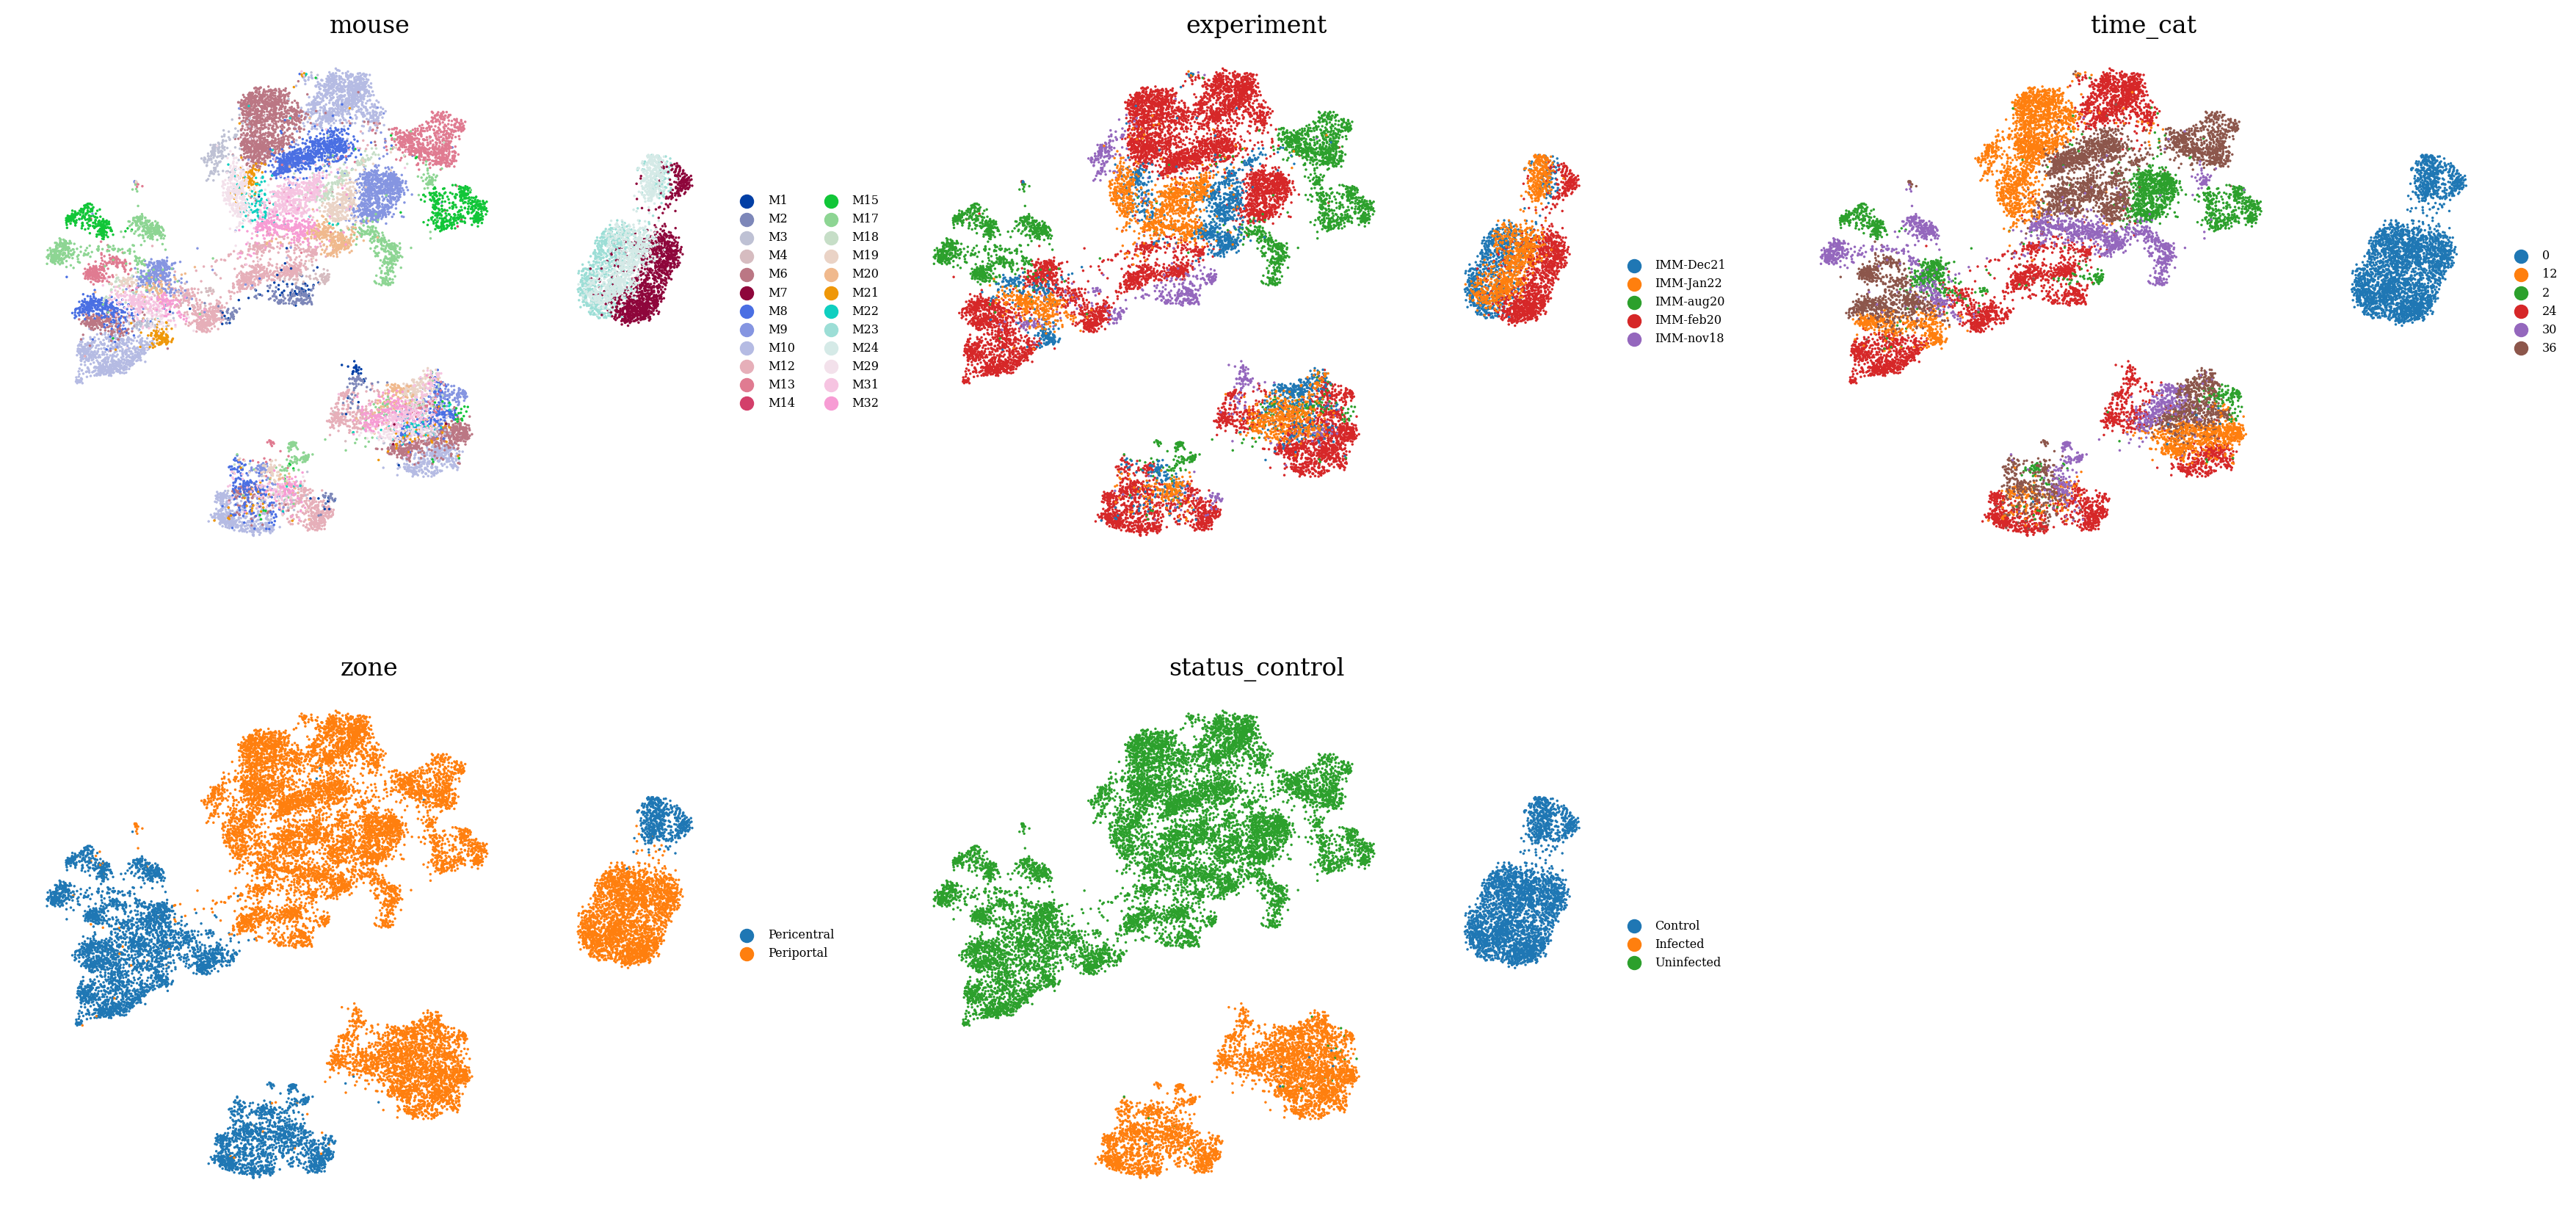

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

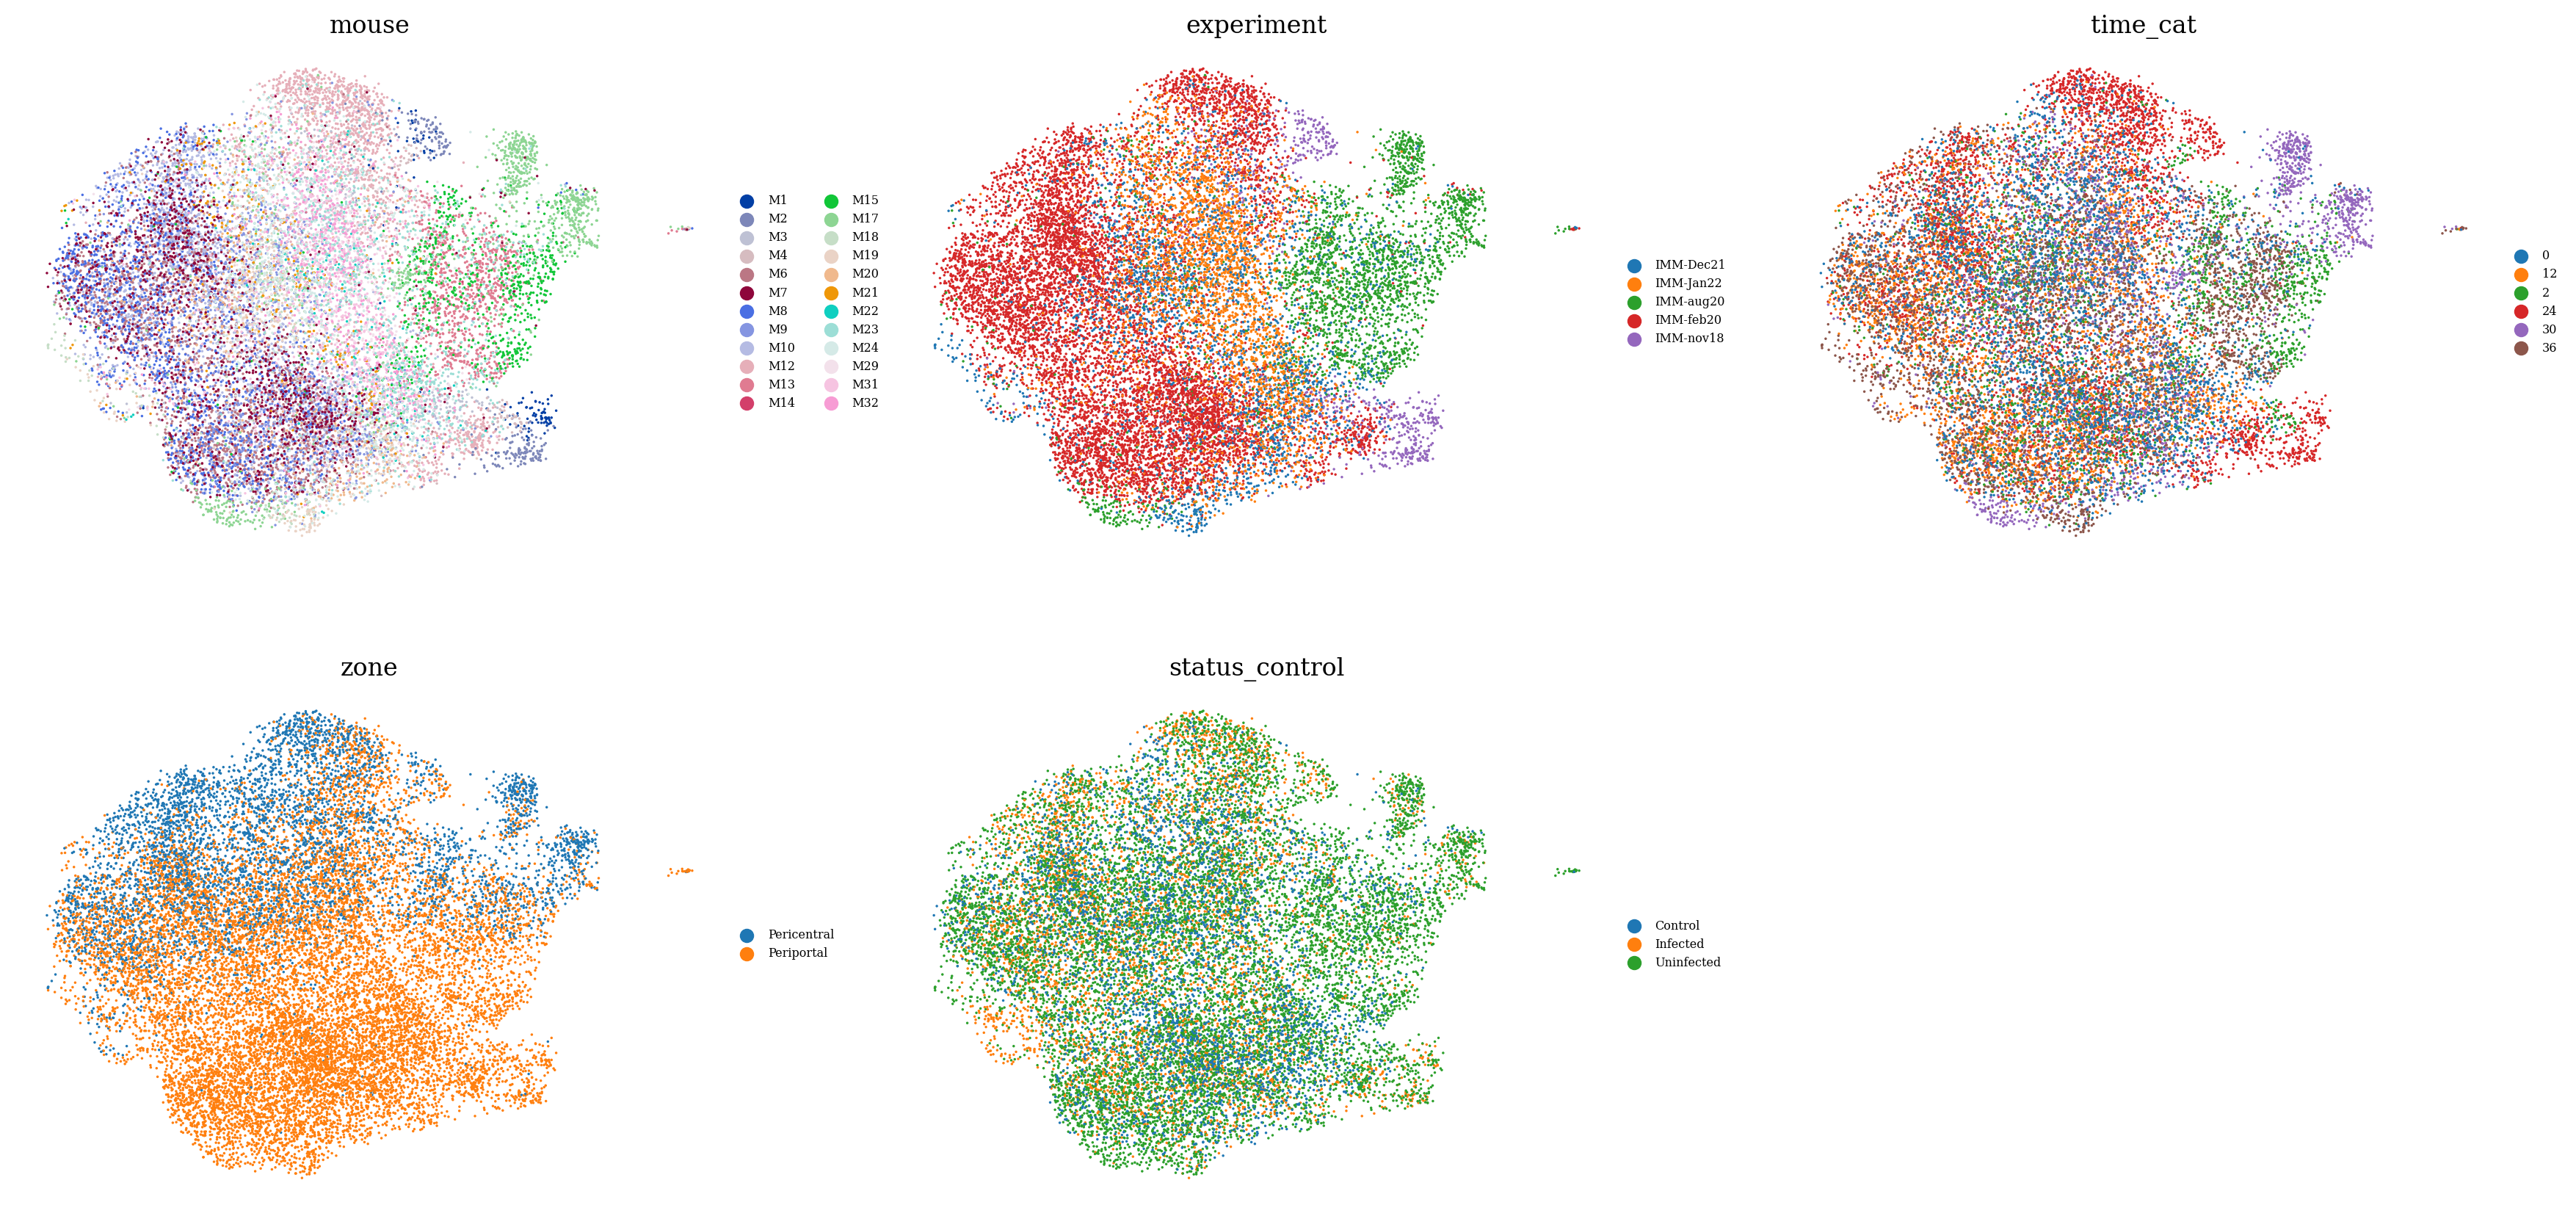

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▍         | 28/596 [00:00<00:02, 274.57it/s]

  9%|▉         | 56/596 [00:00<00:01, 276.25it/s]

 14%|█▍        | 86/596 [00:00<00:01, 285.34it/s]

 19%|█▉        | 116/596 [00:00<00:01, 289.53it/s]

 24%|██▍       | 145/596 [00:00<00:01, 288.19it/s]

 29%|██▉       | 175/596 [00:00<00:01, 288.86it/s]

 34%|███▍      | 205/596 [00:00<00:01, 289.86it/s]

 39%|███▉      | 235/596 [00:00<00:01, 290.43it/s]

 44%|████▍     | 265/596 [00:00<00:01, 291.02it/s]

 49%|████▉     | 295/596 [00:01<00:01, 291.65it/s]

 55%|█████▍    | 325/596 [00:01<00:00, 291.49it/s]

 60%|█████▉    | 355/596 [00:01<00:00, 291.24it/s]

 65%|██████▍   | 385/596 [00:01<00:00, 291.11it/s]

 70%|██████▉   | 415/596 [00:01<00:00, 290.90it/s]

 75%|███████▍  | 445/596 [00:01<00:00, 291.62it/s]

 80%|███████▉  | 475/596 [00:01<00:00, 290.99it/s]

 85%|████████▍ | 505/596 [00:01<00:00, 291.82it/s]

 90%|████████▉ | 535/596 [00:01<00:00, 291.99it/s]

 95%|█████████▍| 565/596 [00:01<00:00, 292.31it/s]

100%|█████████▉| 595/596 [00:02<00:00, 288.27it/s]

100%|██████████| 596/596 [00:02<00:00, 289.28it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

In [23]:
np.mean(r2s)

0.9784383767152327

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)